# Assignment 3 - Building a Custom Visualization

---

In this assignment you must choose one of the options presented below and submit a visual as well as your source code for peer grading. The details of how you solve the assignment are up to you, although your assignment must use matplotlib so that your peers can evaluate your work. The options differ in challenge level, but there are no grades associated with the challenge level you chose. However, your peers will be asked to ensure you at least met a minimum quality for a given technique in order to pass. Implement the technique fully (or exceed it!) and you should be able to earn full grades for the assignment.


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Ferreira, N., Fisher, D., & Konig, A. C. (2014, April). [Sample-oriented task-driven visualizations: allowing users to make better, more confident decisions.](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/Ferreira_Fisher_Sample_Oriented_Tasks.pdf) 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;In Proceedings of the SIGCHI Conference on Human Factors in Computing Systems (pp. 571-580). ACM. ([video](https://www.youtube.com/watch?v=BI7GAs-va-Q))


In this [paper](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/Ferreira_Fisher_Sample_Oriented_Tasks.pdf) the authors describe the challenges users face when trying to make judgements about probabilistic data generated through samples. As an example, they look at a bar chart of four years of data (replicated below in Figure 1). Each year has a y-axis value, which is derived from a sample of a larger dataset. For instance, the first value might be the number votes in a given district or riding for 1992, with the average being around 33,000. On top of this is plotted the confidence interval -- the range of the number of votes which encapsulates 95% of the data (see the boxplot lectures for more information, and the yerr parameter of barcharts).

<br>
<img src="readonly/Assignment3Fig1.png" alt="Figure 1" style="width: 400px;"/>
<h4 style="text-align: center;" markdown="1">  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Figure 1 from (Ferreira et al, 2014).</h4>

<br>

A challenge that users face is that, for a given y-axis value (e.g. 42,000), it is difficult to know which x-axis values are most likely to be representative, because the confidence levels overlap and their distributions are different (the lengths of the confidence interval bars are unequal). One of the solutions the authors propose for this problem (Figure 2c) is to allow users to indicate the y-axis value of interest (e.g. 42,000) and then draw a horizontal line and color bars based on this value. So bars might be colored red if they are definitely above this value (given the confidence interval), blue if they are definitely below this value, or white if they contain this value.


<br>
<img src="readonly/Assignment3Fig2c.png" alt="Figure 1" style="width: 400px;"/>
<h4 style="text-align: center;" markdown="1">  Figure 2c from (Ferreira et al. 2014). Note that the colorbar legend at the bottom as well as the arrows are not required in the assignment descriptions below.</h4>

<br>
<br>

**Easiest option:** Implement the bar coloring as described above - a color scale with only three colors, (e.g. blue, white, and red). Assume the user provides the y axis value of interest as a parameter or variable.


**Harder option:** Implement the bar coloring as described in the paper, where the color of the bar is actually based on the amount of data covered (e.g. a gradient ranging from dark blue for the distribution being certainly below this y-axis, to white if the value is certainly contained, to dark red if the value is certainly not contained as the distribution is above the axis).

**Even Harder option:** Add interactivity to the above, which allows the user to click on the y axis to set the value of interest. The bar colors should change with respect to what value the user has selected.

**Hardest option:** Allow the user to interactively set a range of y values they are interested in, and recolor based on this (e.g. a y-axis band, see the paper for more details).

---

In [16]:
# Use the following data for this assignment:

import pandas as pd
import numpy as np

np.random.seed(12345)

df = pd.DataFrame([np.random.normal(53500,150000,3650), 
                   np.random.normal(41000,90000,3650), 
                   np.random.normal(41000,120000,3650), 
                   np.random.normal(14000,55000,3650)], 
                  index=[1992,1993,1994,1995])
df

,0,1,2,3,4,5,6,7,8,9,...,3640,3641,3642,3643,3644,3645,3646,3647,3648,3649
1992,22793.851077,125341.500709,-24415.807259,-29859.545652,348367.085875,262510.874946,67436.181512,95761.922925,168853.385142,240465.210458,...,158454.070217,142488.069943,182247.982356,-253907.868554,-118410.570396,47638.756441,-13120.047151,-20989.824866,114532.974507,26128.841097
1993,-44406.485331,180815.466879,-108866.427539,-114625.083717,196807.232582,47161.295355,136522.083654,58826.904901,23329.019613,-96417.638483,...,-37809.868064,93228.910228,108183.379950,146728.060346,-10083.899508,-31300.144215,95017.857057,164071.514663,14409.944591,33298.608969
1994,134288.798913,169097.538334,337957.368420,-76005.273164,90130.207911,8453.626320,-24562.317561,195665.400438,-53475.640770,44708.230667,...,145216.405451,67773.006363,95711.194465,174500.629277,-27821.888075,-57881.583140,26321.525617,-21424.067186,60164.652898,-74750.286614
1995,-78485.202120,-34156.410517,-47425.878636,19540.999558,96408.559874,-13554.343776,26336.077232,26688.099156,-46748.496722,23150.175074,...,-34636.804950,15707.896672,18687.564135,-20470.079150,33016.324752,7664.942829,85870.946944,22946.289297,33927.466106,-1160.292001


<IPython.core.display.Javascript object>


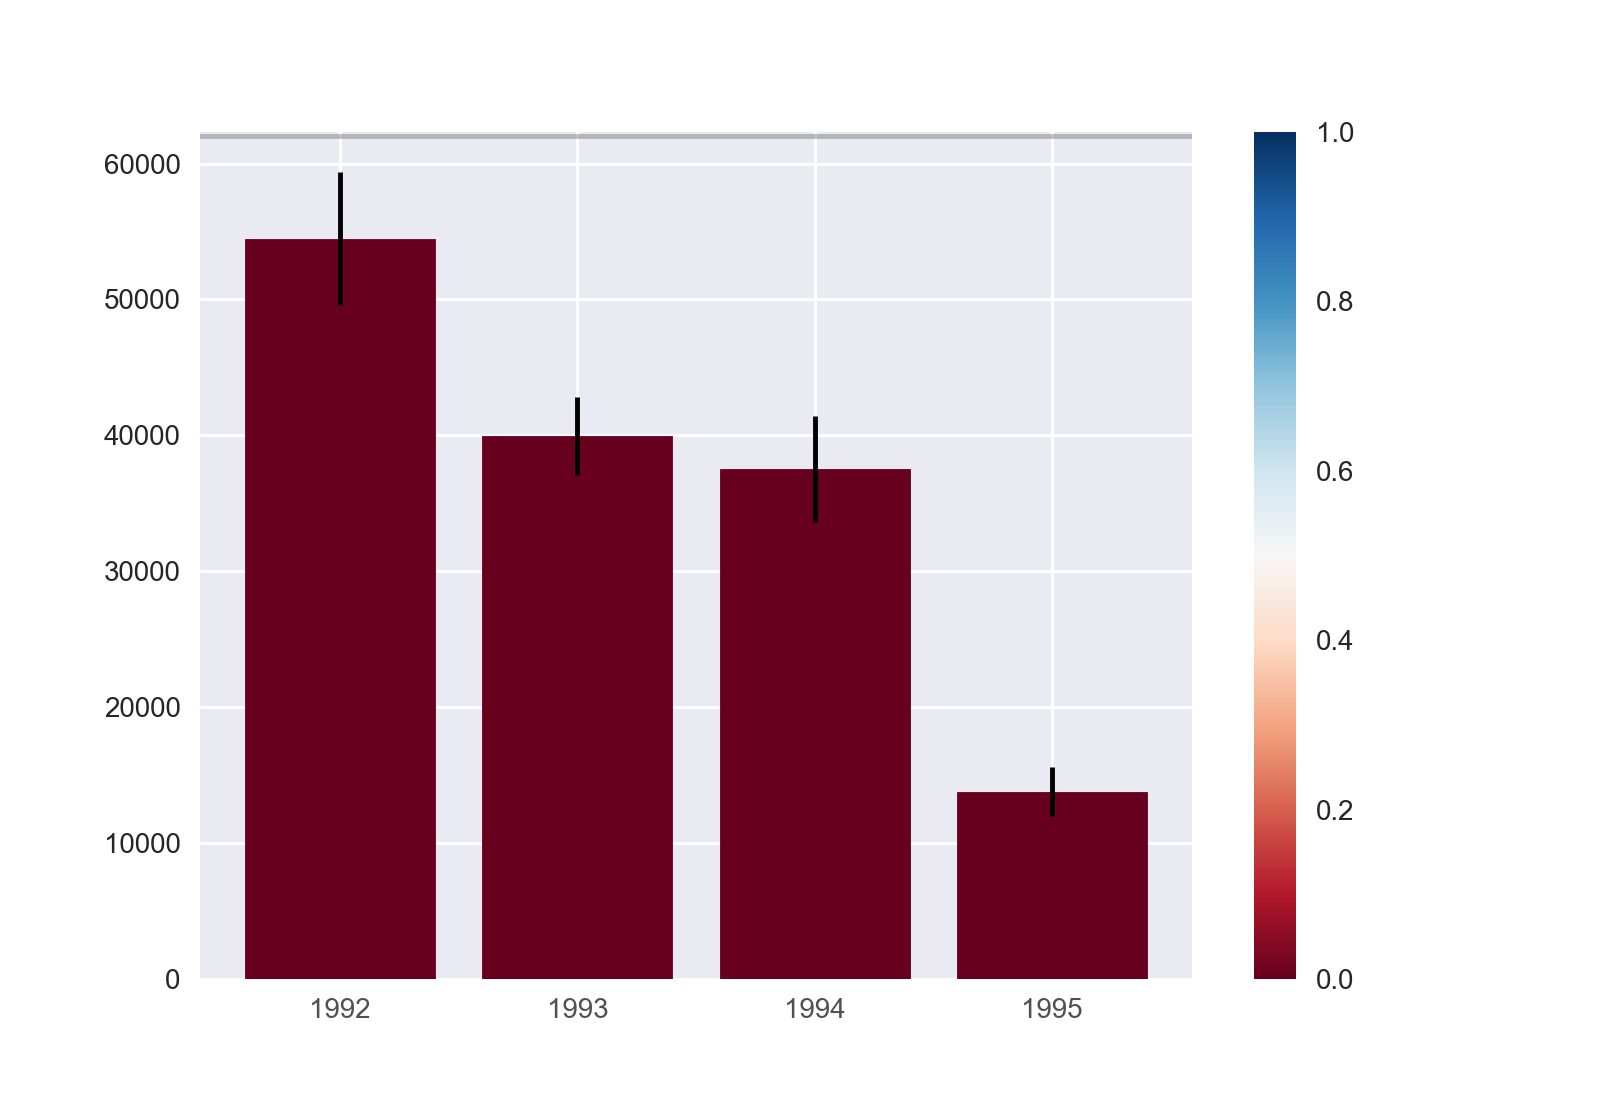

In [37]:
import matplotlib.pyplot as plt
from scipy import stats
import matplotlib.colors as col
import matplotlib.cm as cm
import statsmodels.stats.api as sms # for confidence intervals
from scipy.stats import sem # another confidence 
import mpl_toolkits.axes_grid1.inset_locator as mpl_il
from matplotlib.widgets import Button, Slider
import seaborn as sns

%matplotlib notebook

fig, ax = plt.subplots()
df['errs'] = 1.96 * ( df.std(axis=1) / np.sqrt(3650))
threshold=53500.
bars = plt.bar(range(df.shape[0]), df.mean(axis = 1), color = 'lightslategrey', yerr = df['errs'],capsize=10)
axline = plt.axhline(y = threshold, color = 'grey', alpha = 0.5)

cm1 = plt.cm.RdBu
# cm1 = col.LinearSegmentedColormap.from_list("Test",["b", "white", "purple"])
cpick = cm.ScalarMappable(cmap=cm1) 
cpick.set_array([])
plt.colorbar(cpick, orientation='vertical')

def percentages(threshold):
    percentages = []
    for bar in bars:
        percentage = (bar.get_height()-threshold)/bar.get_height()
        if percentage>1: percentage = 1
        if percentage<0: percentage=0
        percentages.append(percentage)
    return percentages

def update(threshold):
    axline.set_ydata(threshold)
    perc = percentages(threshold)
    for bar, p in zip(bars, perc):
        bar.set_color(cpick.to_rgba(p))

# update once before showing
update(threshold)

def onMouseMove(event):
    if event.inaxes == ax:
        update(event.ydata)
        fig.canvas.draw_idle()

fig.canvas.mpl_connect('motion_notify_event', onMouseMove)

plt.xticks(range(df.shape[0]), df.index, alpha = 0.8)

#plt.show()
plt.savefig("Interactive.svg", format="svg")



In [12]:
class interactiveBarChart:
    """
    A base class that can be used for creating clicable charts and solving
    the challenges of interpreting plots with confidence intervals.
    """
    # basic greys: lighter for regular, darker for emphasis
    greys = ['#afafaf','#7b7b7b'] # ticks and boxes, arrows, legend ticks and text
    # horizontal bar: nice red
    horzo_bar = '#004a80'
    # set bar colormap
    cmap = cm.get_cmap('RdBu')

    # instantiate the class
    def __init__(self): 
        """
        Initialize the data and a new figure.
        """
        # seed for data.
        np.random.seed(12345)
        # get some data to plot
        self.df = pd.DataFrame(np.c_[np.random.normal(33500,150000,3650), # np.c_ class to transpose array
                   np.random.normal(41000,90000,3650), 
                   np.random.normal(41000,120000,3650), 
                   np.random.normal(48000,55000,3650)], 
                  columns=[1992,1993,1994,1995])
        # get mean values to plot
        self.means = self.df.mean()        
        # calculate confidence interval high and low
        self.c_i = [ sms.DescrStatsW(self.df[i]).tconfint_mean() for i in self.df.columns ]
        # calculate the interval whole number
        self.intervals = [ invl[-1] - invl[0] for invl in self.c_i ] 

        # plot the bar chart and make a reference to the rectangles
        self.rects = plt.bar(
            range(len(self.df.columns)), 
            self.means,
            yerr=self.df.sem().values*1.96,
            align='center', 
            alpha=0.8, 
            color=self.greys[0],
            error_kw=dict(ecolor='gray', lw=2, capsize=7, capthick=2)
        )

        # set up a starting axhline
        self.horzo_slider = plt.axhline(y=40000, xmin=-.1, clip_on=False, zorder=1, color='#e82713')

        ## TICKS AND TEXT AND SPINES
        plt.title('Confidence Interval Interactivity: Click the Chart To Recolor', color=self.greys[1])
        plt.xticks(range(len(self.df.columns)), self.df.columns)        
        # do some formatting 
        self.formatArtists(plt.gca())


        ## EVENT HANDLING
        # reference the axes and setup pick events
        plt.gcf().canvas.mpl_connect('button_press_event', self.setAxHLine)


    def formatArtists(self, ax):
        """
        Does some recoloring and formatting of the ticks, labels, and spines.
        Receives the axes of the current figure.
        """
        # recolor the ticks
        ax.xaxis.set_tick_params(which='major', colors=self.greys[1])
        ax.yaxis.set_tick_params(which='major', colors=self.greys[1])

        # recolor the spines
        for pos in ['top', 'right', 'bottom', 'left']:
            ax.spines[pos].set_edgecolor(self.greys[0])


    ## EVENT HANDLERS
    def setAxHLine(self, event): 
        """
        Handle the logic for handling bar coloring when the slider 
        is moved up or down over the confidence intervals.
        """
        # remove first axhline
        self.horzo_slider.remove()
        self.horzo_slider = plt.axhline(y=event.ydata, xmin=-.1, clip_on=False, zorder=1, color='#e82713')
        # self.recolorBars(event)


    def recolorBars(self, event):
        """
        Handles all recoloring of the bars based on the confidence that the selected y-value is within a given interval on the chart.
        This function is called on a button press event and receives that data as an argument.
        """        

        # get the yval 
        y = event.ydata

        # how to determine the shades ?
#         abs_diffs = [ abs((mean + conf)-y|) for mean, conf in zip(self.means, self.intervals) ]

         # how to pass in the map to get the colors to apply to the bars?        
#        colors = [ cm.ScalarMappable(norm=col.Normalize(vmin=i[0] , vmax=i[-1]), cmap=self.cmap) for i in self.c_i ]

        # apply the colors in a list comprehension
        # [ rect.set_color(color) for rect, color in zip(self.rects, colors) ]


    def showPlot(self):
        """
        Convenience if not using the inline display setup %matplotlib notebook
        """
        plt.show()